## imports

In [2]:
import trackpy as tp
import pims
from skimage import color
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob

%matplotlib inline

This is entirely using `http://soft-matter.github.io/trackpy/v0.5.0/tutorial/walkthrough.html`

In [58]:
path = 'debug_data/video-1/video-1/*.bmp'

frames = pims.as_grey(pims.open(path))

Frame 3881: 33 trajectories present.


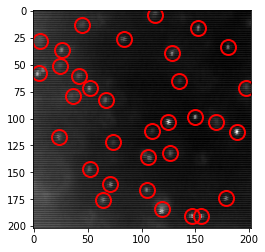

<AxesSubplot:>

In [66]:
loc = tp.batch(frames, diameter=11, minmass=100, separation=2)

In [102]:
link = tp.link(loc, 5, memory=10)
# tp.annotate(loc[loc.frame == 0], frames[0])

Frame 3881: 33 trajectories present.


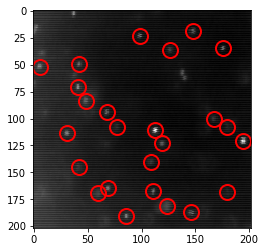

<AxesSubplot:>

In [109]:
drift = tp.compute_drift(link)
# link = tp.subtract_drift(link, drift=drift)
link = tp.filter_stubs(link)

i = 100
tp.annotate(link[link.frame==i], frames[i])

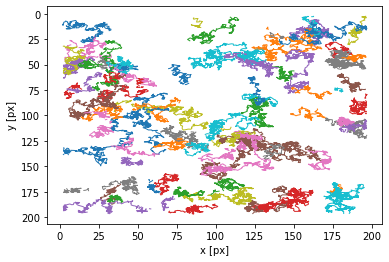

<AxesSubplot:xlabel='x [px]', ylabel='y [px]'>

In [113]:
tp.plot_traj(link[link.frame < 1000])

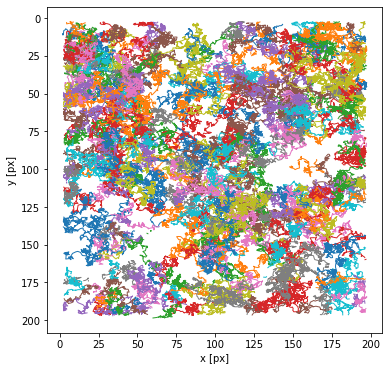

In [124]:
# # replace with your own
# data_path = 'data_out/2021_Oct_13/06:15:48-PM_50-frames.csv'

# tracks = pd.read_csv(data_path)
# stable = tp.subtract_drift(tracks, tp.compute_drift(tracks))

fig,ax = plt.subplots(figsize=(6,6))
tp.plot_traj(link)
ax.set_aspect('equal')
plt.show()

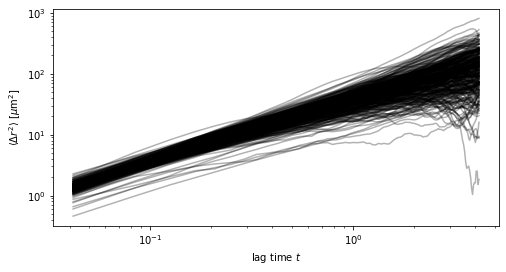

In [121]:
microns_per_pixel = 1
frames_per_second = 24

mean_square_disp = tp.imsd(link, microns_per_pixel, frames_per_second)
fig,ax = plt.subplots(figsize=(8,4))
ax.plot(mean_square_disp.index, mean_square_disp, 'k-', alpha=.3)
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel='lag time $t$')
ax.set_yscale('log')
ax.set_xscale('log')

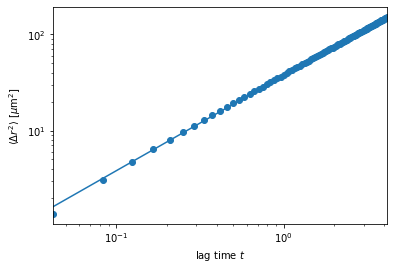

,n,A
msd,0.991785,37.406395


In [120]:
em = tp.emsd(link, microns_per_pixel, frames_per_second)

fig, ax = plt.subplots()
# ax.plot(em.index, em, 'o')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel='lag time $t$')

tp.utils.fit_powerlaw(em) 
